                                  run  brojPoslanihPaketa repetition  \
0    General-0-20180701-01:08:07-8369               480.0          0   
1    General-1-20180701-01:08:07-8369               480.0          1   
2   General-10-20180701-01:08:10-8369               870.0          0   
3   General-11-20180701-01:08:11-8369               870.0          1   
4   General-12-20180701-01:08:12-8369               540.0          0   
5   General-13-20180701-01:08:12-8369               540.0          1   
6   General-14-20180701-01:08:13-8369               360.0          0   
7   General-15-20180701-01:08:13-8369               360.0          1   
8   General-16-20180701-01:08:13-8369              2400.0          0   
9   General-17-20180701-01:08:15-8369              2400.0          1   
10  General-18-20180701-01:08:18-8369              1450.0          0   
11  General-19-20180701-01:08:19-8369              1450.0          1   
12   General-2-20180701-01:08:08-8369               290.0       

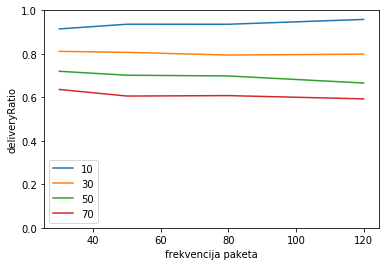

In [65]:
import pandas as pd
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('time-freq.csv', usecols = ["run","attrname", "name", "value", "type", "attrvalue"]) #, usecols = ["run","attrname" "name", "value", "type"])

sentPacketsDf = df[(df.name == 'sentPackets')]

#broj cvorova u pojedinom run-u
sentPacketsByNumberOfNodes = sentPacketsDf.groupby(['run']).size().reset_index(name='brojCvorova')
#print(sentPacketsByNumberOfNodes)

#ukupan broj poslanih paketa po pojedinom run-u
sentPacketsByNodesTotal = sentPacketsDf.groupby(['run']).sum()
#print(sentPacketsByNodesTotal['value'])
sentPacketsByNodesTotal.rename(columns={'value': 'brojPoslanihPaketa'}, inplace=True)

#broj ponavaljanja po pojedinom run-u
repetition = df[(df.attrname == 'repetition')]
repetition.rename(columns={'attrvalue': 'repetition'}, inplace=True)

#frekvencija slanja paketa po pojedinom run-u
sendingFreq = df[(df.attrname) == 'iterationvars']
sendingFreq.rename(columns={'attrvalue': 'frekvSlanja'}, inplace=True)

#broj primljeni paketa na GW po pojedinom run-u
packetReceivedDf = df[(df.name == 'LoRa_GWPacketReceived:count') & (df.type == 'scalar')]
#print(packetReceivedDf)
packetReceivedDf.rename(columns={'value': 'brojPrimPkGW'}, inplace=True)
#packetReceivedByGateway = packetReceivedDf.groupby(['run'], as_index = False )
#packetReceivedByGatewayGroupedBy = packetReceivedDf.groupby(['run'])

run = []
frekvSlanja = []
for index, row in sendingFreq.iterrows():
    run.append(row.run)
    s = row.frekvSlanja
    s = s.split('=')
    s = s[3].split(',')
    frekvSlanja.append(int(s[0].strip('(min')))
    #print(run + ' ' + frekvSlanja)
#novi dataframe koji ce sadrzavati stupce run i frekvSlanja
df_sendingFreq = pd.DataFrame({'run': run, 'frekvSlanja': frekvSlanja})
#print("\n\n Sending freq\n")
#print(df_sendingFreq)
    
    
df = pd.merge(sentPacketsByNodesTotal, repetition[['run','repetition']], on='run')
df2 = pd.merge(df, sentPacketsByNumberOfNodes, on='run')
#df3 = pd.merge(df2, sendingFreq, on='run')
df3 = pd.merge(df2, df_sendingFreq, on='run')
df4 = pd.merge(df3, packetReceivedDf[['run','brojPrimPkGW']], on='run')
print(df4)

dfSort = df4.sort_values(['frekvSlanja','brojCvorova', 'repetition']).reset_index(drop=True)
print("Sortirani dataframe po frekvslanja a zatim po repetitionu\n")
print(dfSort)

tmp = []
curFrekvSlanja = dfSort.iloc[0]['frekvSlanja']
print(curFrekvSlanja)
print(type(curFrekvSlanja))
curBrojCvorova = int(dfSort.iloc[0]['brojCvorova'])

print(curBrojCvorova)
print(type(curBrojCvorova))
sumDeliveryRatio = 0.0
repetition = 0

for index, row in dfSort.iterrows():
    if((row.frekvSlanja == curFrekvSlanja) & (row.brojCvorova == curBrojCvorova)):
        print("prvi if")
        if(row.brojPrimPkGW != 0):
            print("Drugi if")

            sumDeliveryRatio = sumDeliveryRatio + (row.brojPrimPkGW/row.brojPoslanihPaketa)
            repetition = repetition + 1
        else:
            sumDeliveryRatio = sumDeliveryRatio + 0

    
    else:
        if(sumDeliveryRatio != 0.0):
            tmp.append([curFrekvSlanja, (sumDeliveryRatio/repetition), curBrojCvorova])
        else:
            tmp.append([curFrekvSlanja, 0.0, curBrojCvorova])
        sumDeliveryRatio = 0
        repetition = 0
        curFrekvSlanja = row.frekvSlanja
        curBrojCvorova = row.brojCvorova
        if (row.brojPrimPkGW != 0):
            sumDeliveryRatio = sumDeliveryRatio + (row.brojPrimPkGW/row.brojPoslanihPaketa)
            repetition = repetition + 1

            
if(sumDeliveryRatio != 0.0):
    tmp.append([curFrekvSlanja, (sumDeliveryRatio/repetition), curBrojCvorova])
else:
    tmp.append([curFrekvSlanja, 0.0, curBrojCvorova])
    
print(tmp)
tmp.sort(key=lambda x: x[0])
print("\nNakon sortiranja\n")
print(tmp)

brojCV = 0
yAxis100cvorova = []
yAxis200cvorova = []
yAxis300cvorova = []
yAxis400cvorova = []
yAxis500cvorova = []
yAxis600cvorova = []
yAxis700cvorova = []
xAxis = []
for item in tmp:
    if item[0] not in xAxis:
        print("item is in array already")
        xAxis.append(item[0])
    brojCV = item[2]
    if (brojCV == 10):
        yAxis10cvorova.append(item[1]);
    elif (brojCV == 30):
        yAxis30cvorova.append(item[1]);
    elif (brojCV == 50):
        yAxis50cvorova.append(item[1]);
    elif (brojCV == 70):
        yAxis70cvorova.append(item[1]);
    else:
        print("Delivery ratio se zeli spremiti u nepostojece polje!")

print(xAxis)
print(yAxis10cvorova)
print(yAxis30cvorova)
print(yAxis50cvorova)
print(yAxis70cvorova)

plt.plot(xAxis, yAxis100cvorova, label = '100')
plt.plot(xAxis, yAxis200cvorova, label = '200')
plt.plot(xAxis, yAxis300cvorova, label = '300')
plt.plot(xAxis, yAxis400cvorova, label = '400')
plt.plot(xAxis, yAxis500cvorova, label = '500')
plt.plot(xAxis, yAxis600cvorova, label = '600')
plt.plot(xAxis, yAxis700cvorova, label = '700')

#plt.plot(xAxis, yAxis10cvorova, label = '10')
#plt.plot(xAxis, yAxis30cvorova, label = '30')
#plt.plot(xAxis, yAxis50cvorova, label = '50')
#plt.plot(xAxis, yAxis70cvorova, label = '70')

plt.legend()
plt.xlabel('frekvencija paketa')
plt.ylabel('deliveryRatio')
plt.ylim(ymax = 1, ymin = 0)
plt.show()
    